In [1]:
%matplotlib inline

In [2]:
from helpers_savage import parse_savages_data, parse_sale_data, parse_listing_data

import requests
import pandas as pd
from pandas_profiling import ProfileReport
import pickle

from statistics import *

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import time
from datetime import date, timedelta, datetime

import os
import glob

#### Getting savages Assets Data

The code below collects assets data about the 10,101 savages. The API has a limit of 50 items per call, and therefore we need to create a loop with 204 iterations to collect all savages data.

##### savage Data Parsed:
- 'savage_id'
- 'creator_username'
- 'creator_address'
- 'owner_username'
- 'owner_address'
- 'traits'
- 'num_sales'

In [13]:
def download_savages_info(save_location):
    url = "https://api.opensea.io/api/v1/assets"
    listometas = []

    for i in range(0, 204):
        time.sleep(.5)
        querystring = {"token_ids":list(range((i*50), (i*50)+50)),
                       "asset_contract_address":"0xF08f985168640d77c87BF14C603351ad10F484A3",
                       "order_direction":"desc",
                       "offset":"0",
                       "limit":"50"}
        response = requests.request("GET", url, params=querystring)

        print(i, end=" ")
        if response.status_code != 200:
            print('error')
            print(response.json())
            break
            

        # Getting savages data
        savages = response.json()['assets']
        
        if savages == []:
            break
        # Parsing savages data
        parsed_savages = [parse_savages_data(savage) for savage in savages]
        # storing parsed savages data into list
        listometas.append(parsed_savages)
    
    # Flatten everything into one list
    listometas = [item for sublist in listometas for item in sublist]
    # Convert to df
    savages_df = pd.DataFrame(listometas)
    
    with open(save_location + 'savages_df'+str(date.today())+r'.pkl', 'wb') as f:
        pickle.dump(savages_df, f)

#### Getting savages sales transactions data

The code below collects all sale transactions data. 
The API has a limit of 300 items per call and 10,000 items total / response. 
Days with > 10,000 sales will require chunking (built in) but most projects aren't there yet.

##### Sales Data Parsed
- 'is_bundle'
- 'savage_id'
- 'seller_address'
- 'buyer_address'
- 'buyer_username'
- 'seller_username'
- 'timestamp'
- 'total_price'
- 'payment_token'
- 'usd_price'
- 'transaction_hash'

In [14]:
# Download sales info from start_date to end _date and save them all into their own day's files
# Default values to first sale ever 7/30/21 to today
def download_sales_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save sales for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        sales_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)
        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 100):
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":"0xF08f985168640d77c87BF14C603351ad10F484A3",
                               "event_type":"successful",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting savages sales data
                savage_sales = response.json()['asset_events']

                if savage_sales == []:
                    keepgoing = False
                    break

                # Parsing savages sales data
                parsed_savage_sales = [parse_sale_data(sale) for sale in savage_sales]
                # storing parsed savages data into list
                sales_that_day.append(parsed_savage_sales)
                # check if the last date in the list is the same day as 
                last_date = (datetime.strptime(parsed_savage_sales[0]['timestamp'], '%Y-%m-%dT%H:%M:%S'))
                print(last_date)
            if end:
                break
        sales_that_day = [item for sublist in sales_that_day for item in sublist]
        
        print(str(len(sales_that_day))+ " sales saved to" + save_location + "savages_sales_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "savages_sales_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(sales_that_day, f)


#### Getting savages listings transactions data

The code below collects all listings of savages on OpenSea. 
The API has a limit of 300 items per call and 10,000 items total / response. 
Days with > 10,000 listings will require chunking (built in).


##### Listing Data Parsed:
- 'is_bundle'
- 'savage_id'
- 'seller_address'
- 'seller_username'
- 'created_date'
- 'starting_price'
- 'payment_token'
- 'usd_price'

In [15]:
# Download listings info from start_date to end _date and save them all into their own day's files
# Default values to first listing ever 7/30/21 to today
def download_listings_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save listings for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        listings_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)
        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 35):
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":"0xF08f985168640d77c87BF14C603351ad10F484A3",
                               "event_type":"created",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting savages listings data
                savage_listings = response.json()['asset_events']

                if savage_listings == []:
                    keepgoing = False
                    break

                # Parsing savages listings data
                parsed_savage_listings = [parse_listing_data(listing) for listing in savage_listings]
                # storing parsed savages data into list
                listings_that_day.append(parsed_savage_listings)
                # check if the last date in the list is the same day as 
                print(parsed_savage_listings[0]['created_date'])
            if end:
                break
        listings_that_day = [item for sublist in listings_that_day for item in sublist]
        
        print(str(len(listings_that_day))+ " listings saved to" + save_location +
              "savages_listings_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "savages_listings_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(listings_that_day, f)

#### Each of the download files saves a pickled list / DF  of their information which can be loaded below for analysis
Sales and Listings downloads support start_date and end_date to avoid taking extra time to download old days of data. 

In [16]:
save_location = "./data/"

# savageS
download_savages_info(save_location)

# SALES
# download sales info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of sales to today

download_sales_info(save_location = save_location, start_date = date(2021,6,19))

# LISTINGS
# download listings info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of listings to today

download_listings_info(save_location = save_location, start_date = date(2021,6,19))

0 1 2 0 0 sales saved to./data/savages_sales_list_2021-06-19.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-20.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-21.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-22.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-23.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-24.pkl
0 2021-06-25 03:57:53
1 1 sales saved to./data/savages_sales_list_2021-06-25.pkl
0 2021-06-26 00:34:40
1 1 sales saved to./data/savages_sales_list_2021-06-26.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-27.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-28.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-29.pkl
0 0 sales saved to./data/savages_sales_list_2021-06-30.pkl
0 2021-07-01 11:48:22
1 1 sales saved to./data/savages_sales_list_2021-07-01.pkl
0 0 sales saved to./data/savages_sales_list_2021-07-02.pkl
0 0 sales saved to./data/savages_sales_list_2021-07-03.pkl
0 2021-07-04 15:41:15
1 1 sales saved to./d

#### Functions for loading data from pickled files

In [17]:
# load the sales lists, combine them, and turn into a DF
def load_sales_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('savages_sales')]
    all_sales = []
    # load all files for sales by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_sales.append(pickle.load(f))
    
    # flatten into one list
    all_sales = [item for sublist in all_sales for item in sublist]
    # convert to dataframe
    savages_sales_df = pd.DataFrame(all_sales)
    
    return savages_sales_df

# load the listing lists, combine them, and turn into a DF
def load_listings_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('savages_listing')]
    all_listings = []
    # load all files for listings by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_listings.append(pickle.load(f))
    
    # flatten into one list
    all_listings = [item for sublist in all_listings for item in sublist]
    # convert to dataframe
    savages_listings_df = pd.DataFrame(all_listings)
    
    return savages_listings_df

# load most recent saved savages df
def load_savages_info(save_location):
    files = glob.glob(str(save_location)+'savages_df????-??-??.pkl')
    with open(max(files, key=os.path.getctime), 'rb') as f:
        return pickle.load(f)

#### Load and pre-process our saved files

In [18]:
# load all our saved files

# SALES
savages_sales_df = load_sales_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
savages_sales_df = savages_sales_df[(savages_sales_df['payment_token'] != 'USDC') & (savages_sales_df['is_bundle'] == False)].copy()
savages_sales_df = savages_sales_df.loc[savages_sales_df.astype(str).drop_duplicates().index]
savages_sales_df['total_price'] = savages_sales_df['total_price']/10.**18
# Change timestamp to datetime
savages_sales_df['timestamp'] = pd.to_datetime(savages_sales_df['timestamp'])
# Calculating the sale prices in USD
savages_sales_df['total_price_usd'] = savages_sales_df['total_price'] * savages_sales_df['usd_price']


# LISTINGS
savages_listings_df = load_listings_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
savages_listings_df = savages_listings_df[(savages_listings_df['payment_token'] != 'USDC') & (savages_listings_df['is_bundle'] == False)].copy()
savages_listings_df = savages_listings_df.loc[savages_listings_df.astype(str).drop_duplicates().index]
savages_listings_df['starting_price'] = savages_listings_df['starting_price']/10.**18
# Change timestamp to datetime
savages_listings_df['created_date'] = pd.to_datetime(savages_listings_df['created_date'])
# Calculating the sale prices in USD
savages_listings_df['total_price_usd'] = savages_listings_df['starting_price'] * savages_listings_df['usd_price']


# savageS
savages_df = load_savages_info(save_location)

In [19]:
savages_df.head(5)

,savage_id,creator_username,creator_address,owner_username,owner_address,traits,num_sales
0,20,None,None,flashrekt,0x2e0d63ffcb08ea20ff3acdbb72dfec97343885d2,[],0
1,18,None,None,FI5HY,0xba764fc3aa1d03967edf9e6414b1796fdc089d5d,[],0
2,17,None,None,FatBabyNFT,0xcc008786d438ba1503f96e392e2049f5b2102277,[],0
3,16,None,None,Domino,0xbf46d2161045251cb97d0b41929bc1d36044e1a0,[],0
4,15,None,None,CryptoGeisha,0x5c835eb9ece4c2c5786251d787ca2ea8c5020b38,[],0


In [20]:
savages_sales_df.tail(5)

,is_bundle,BAYC_id,seller_address,buyer_address,buyer_username,seller_username,timestamp,total_price,payment_token,usd_price,transaction_hash,total_price_usd
16,False,63,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,0x265f4aa6fa5e8fb9b76fe465c4d1e00ffe167d22,Yeez,SavageDogs,2021-07-24 09:04:05,0.75,ETH,3141.34,0x77f34c66d4e0031c9eead0dd8388b1b144ecff95d94f...,2356.0050
17,False,67,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,0x44d5a0b1e165a17c16d940ca774a28e62d4b44b0,daliso,SavageDogs,2021-07-29 19:23:15,0.69,ETH,3141.34,0x879dca99b8d5ac57273d92b6c8618955de49047c1793...,2167.5246
18,False,68,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,0xe1ff19610020d72930aee1b9c047e35b7fd0080e,NinjaBoffin,SavageDogs,2021-07-30 21:37:56,0.70,ETH,3141.34,0xdf4a28b6ca52b3fbdc7e745c5254e444d2e53dabe469...,2198.9380
19,False,76,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,0x44d5a0b1e165a17c16d940ca774a28e62d4b44b0,daliso,SavageDogs,2021-08-05 20:54:19,0.69,ETH,3141.34,0x9155dd5e73de037fec572915d563b2ea07fce560261b...,2167.5246
20,False,77,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,0xbdc4a5c0ff7275736cad102c7408555fb5d6c495,blocknoob,SavageDogs,2021-08-05 07:09:12,0.81,ETH,3141.34,0x7801ef411107fd5c29d59736b62b622ba8ae6ba390fc...,2544.4854


## Analyzing savages Data and savages Sale Transactions

In [21]:
print("The database has information about %d savages." % len(savages_df))
print("The database has information about %d savages sale transactions." % len(savages_sales_df))
print("The database has information about %d savages listing transactions." % len(savages_listings_df))

The database has information about 57 savages.
The database has information about 21 savages sale transactions.
The database has information about 25 savages listing transactions.


In [22]:
# pandas profiling reports
"""
savage_report = ProfileReport(savages_df, title="savages Report", explorative=True)
savage_sales_report = ProfileReport(savages_sales_df, title="savage Sales Report", explorative=True)
savage_report.to_file("savage_report.html")
savage_sales_report.to_file("savage_sales_report.html")
"""

'\nsavage_report = ProfileReport(savages_df, title="savages Report", explorative=True)\nsavage_sales_report = ProfileReport(savages_sales_df, title="savage Sales Report", explorative=True)\nsavage_report.to_file("savage_report.html")\nsavage_sales_report.to_file("savage_sales_report.html")\n'

### Analyzing savages' Sellers and Buyers

In [23]:
print("There are %d unique savage sellers." % len(savages_sales_df['seller_address'].unique()))
print("There are %d unique savage buyers." % len(savages_sales_df['buyer_address'].unique()))

There are 1 unique savage sellers.
There are 18 unique savage buyers.


#### Getting Top 10 savages Buyers

In [24]:
buyers = []
for buyer_address in savages_sales_df['buyer_address'].value_counts().index[:10]:
    buyer_data = {}
    buyer_data['buyer_address'] = buyer_address
    buyer_data['buyer_username'] = savages_sales_df[savages_sales_df['buyer_address'] == buyer_address]['buyer_username'].iloc[0]
    buyer_data['number_buys'] = len(savages_sales_df[savages_sales_df['buyer_address'] == buyer_address])
    buyer_data['min_price'] = savages_sales_df[savages_sales_df['buyer_address'] == buyer_address]['total_price'].min()
    buyer_data['max_price'] = savages_sales_df[savages_sales_df['buyer_address'] == buyer_address]['total_price'].max()
    buyer_data['mean_price'] = savages_sales_df[savages_sales_df['buyer_address'] == buyer_address]['total_price'].mean()
    buyers.append(buyer_data)
    
pd.DataFrame(buyers)

,buyer_address,buyer_username,number_buys,min_price,max_price,mean_price
0,0x44d5a0b1e165a17c16d940ca774a28e62d4b44b0,daliso,3,0.69,0.75,0.710
1,0x1e30bf87bc3d7ea53d9d6999fe886e6b20c8c9a4,veens,2,0.80,0.95,0.875
2,0x9482c72cb018ee03d8c23395038b510ed4e6040c,bettor,1,0.69,0.69,0.690
3,0x51047ac8977d0dd35f3e1f35d75ddf81b8989f3d,cananapo,1,0.75,0.75,0.750
4,0xc58962d01d35a5746c1724e1a67251067eb3bc46,lol_VEVO,1,0.13,0.13,0.130
5,0xbdc4a5c0ff7275736cad102c7408555fb5d6c495,blocknoob,1,0.81,0.81,0.810
6,0x63f42bfc17b6ff3a7f487c406b8e006d0d4970c3,ultraparadise,1,0.75,0.75,0.750
7,0x69658f46ecc6529e18a6fceae79536c2239d5006,None,1,0.50,0.50,0.500
8,0x9fe2a1733b00b36ff4ca2c2883940e4d92f6e024,1337kodiak,1,0.70,0.70,0.700
9,0x265f4aa6fa5e8fb9b76fe465c4d1e00ffe167d22,Yeez,1,0.75,0.75,0.750


#### Getting Top 10 savages Sellers

In [25]:
sellers = []
for seller_address in savages_sales_df['seller_address'].value_counts().index[:10]:
    seller_data = {}
    seller_data['seller_address'] = seller_address
    seller_data['seller_username'] = savages_sales_df[savages_sales_df['seller_address'] == seller_address]['seller_username'].iloc[0]
    seller_data['number_sales'] = len(savages_sales_df[savages_sales_df['seller_address'] == seller_address])
    seller_data['min_price'] = savages_sales_df[savages_sales_df['seller_address'] == seller_address]['total_price'].min()
    seller_data['max_price'] = savages_sales_df[savages_sales_df['seller_address'] == seller_address]['total_price'].max()
    seller_data['mean_price'] = savages_sales_df[savages_sales_df['seller_address'] == seller_address]['total_price'].mean()
    sellers.append(seller_data)
    
pd.DataFrame(sellers)

,seller_address,seller_username,number_sales,min_price,max_price,mean_price
0,0xfccb96245ece8c0c0ba80992a5719cba1e2f504f,SavageDogs,21,0.13,1.5,0.654286


#### Intersection of Top 10 Buyers and Top 10 sellers

In [26]:
top_10_buyers = savages_sales_df['buyer_username'].value_counts().index[:10]
top_10_sellers = savages_sales_df['seller_username'].value_counts().index[:10]
print(list(set(top_10_buyers) & set(top_10_sellers)))

[]


#### Getting Number of Sales between same Buyers and Sellers 

In [27]:
(savages_sales_df['seller_address'] + savages_sales_df['buyer_address']).value_counts().value_counts()

1    16
2     1
3     1
dtype: int64

## Analyzing Average Price of Each Trait

### Getting Top 10 savages Owners

In [28]:
owners = []
for owner_address in savages_df['owner_address'].value_counts().index[:10]:
    owner_data = {}
    owner_data['owner_address'] = owner_address
    owner_data['owner_username'] = savages_df[savages_df['owner_address'] == owner_address]['owner_username'].iloc[0]
    owner_data['number_savages'] = len(savages_df[savages_df['owner_address'] == owner_address])
    owners.append(owner_data)

pd.DataFrame(owners)

,owner_address,owner_username,number_savages
0,0x0000000000000000000000000000000000000000,NullAddress,7
1,0xe1ff19610020d72930aee1b9c047e35b7fd0080e,NinjaBoffin,6
2,0x44d5a0b1e165a17c16d940ca774a28e62d4b44b0,daliso,3
3,0x1e30bf87bc3d7ea53d9d6999fe886e6b20c8c9a4,veens,2
4,0x63f42bfc17b6ff3a7f487c406b8e006d0d4970c3,ultraparadise,2
5,0xa1447daa4d91e1c75eff3ee80b33e12935fbbec0,Hxden,1
6,0x784e1a0b0be5e64fefe67e7f483f0bd08ef4c13f,SionTheArtist,1
7,0xd59120f2a160c9862301c1f3bb5f171279f95512,Anocam,1
8,0xb02c3a77a6631bb1598080d77ca596f1f69b3f60,NoSleepJon,1
9,0x76591d601c932ff2a9a6d35b8d74d09f2e7b3593,AK_Evernew,1


In [29]:
#### Getting total number of savage Creators and Owners.
print("There are %d unique savages creators." % len(savages_df['creator_address'].unique()))
print("There are %d unique savages owners." % len(savages_df['owner_address'].unique()))

There are 2 unique savages creators.
There are 42 unique savages owners.


# Visualizations

### savages Sales Timelines

#### Total Number of Sales per Day

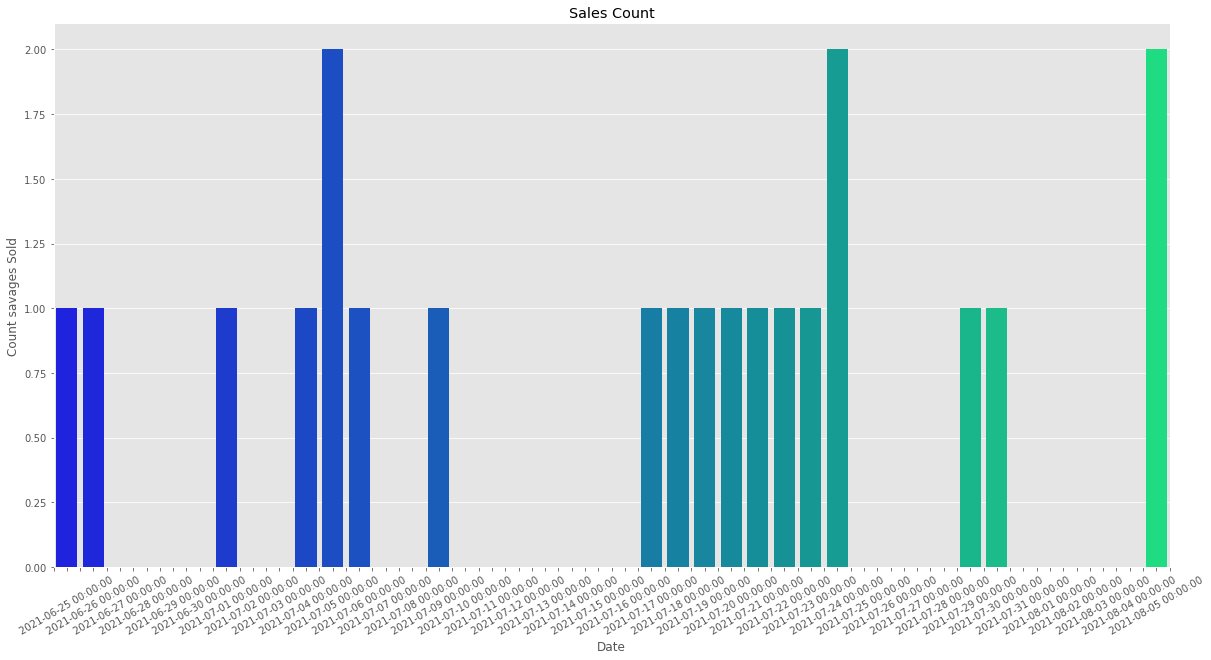

In [30]:
data = savages_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').count()['total_price']
data = pd.DataFrame(data)
data.columns = ['Count savages Sold']
#ax = data.plot.bar(figsize=(18, 5))

plt.figure(figsize=(20,10))
ax = sns.barplot(x=data.index, y=data['Count savages Sold'], palette="winter")
plt.xlabel("Date")
plt.title("Sales Count")

ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);
ax.xaxis.set_major_locator(plt.MaxNLocator(100));

#### Total Sales per Day in ETH

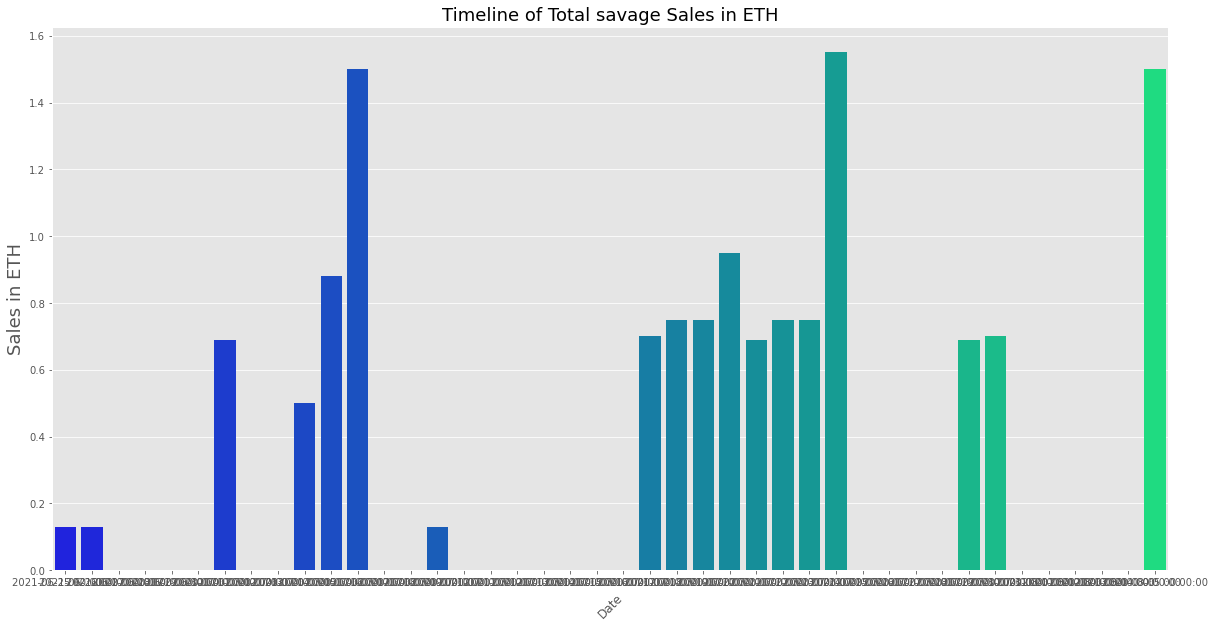

In [31]:
data = savages_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').sum()['total_price']
data = pd.DataFrame(data)
data.columns = ['total_price']

plt.figure(figsize=(20,10))
ax=sns.barplot(x=data.index, y=data['total_price'], palette="winter")
plt.xlabel("Date", rotation=45)
plt.title("Sales Count")

ax.set_title("Timeline of Total savage Sales in ETH", fontsize=18)
ax.set_ylabel("Sales in ETH", fontsize=18);


#### Total Sales per day in USD

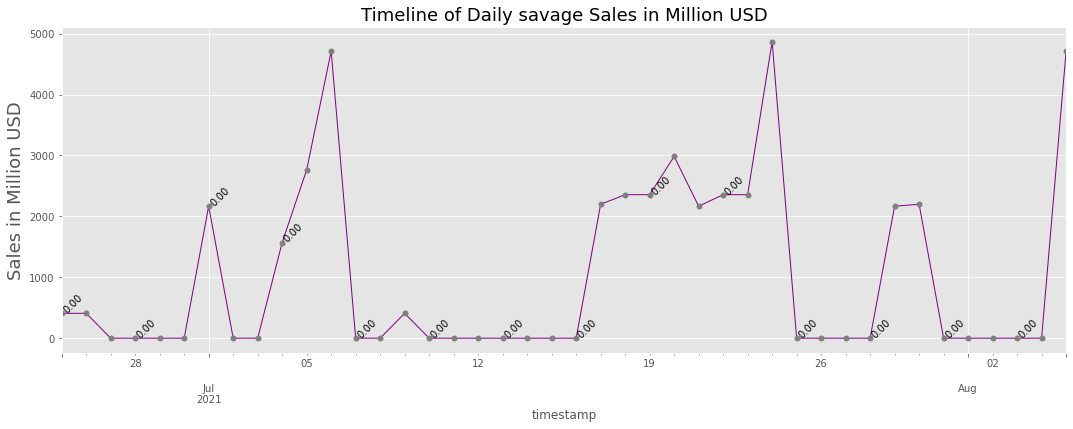

In [32]:
data = savages_sales_df[['timestamp', 'total_price_usd']].resample('D', on='timestamp').sum()['total_price_usd']
ax = data.plot(figsize=(18,6), color="purple", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Daily savage Sales in Million USD", fontsize=18)
ax.set_ylabel("Sales in Million USD", fontsize=18);

dates = list(data.index)
values = list(data.values)

for idx,(i, j) in enumerate(zip(dates, values)):
    if idx % 3 == 0:
        ax.annotate(text="{:.2f}".format(j/10.**6), xy=(i, j), rotation=45)

### savages Sales Prices Timelines 

#### Average savage Price per Day in ETH 

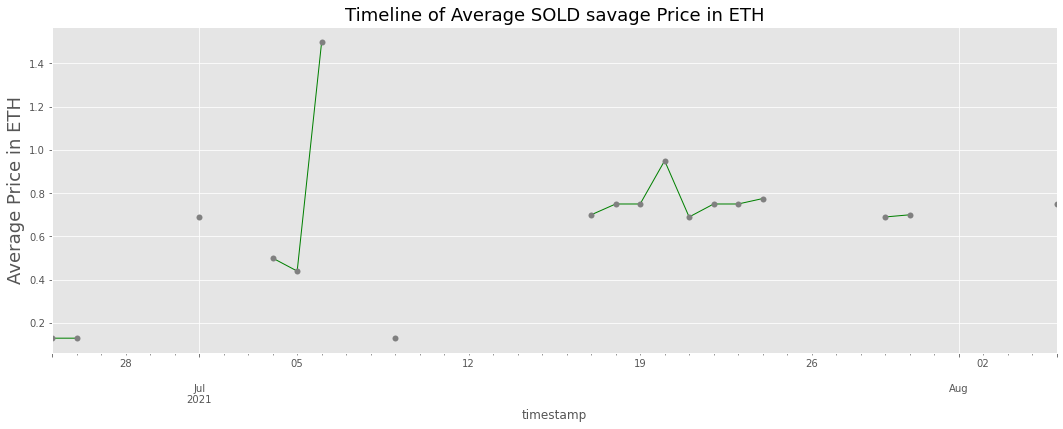

In [33]:
data = savages_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').mean()['total_price']
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Average SOLD savage Price in ETH", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18);
#ax.annotate(s='sdsdsds', xy=(1, 1))

dates = list(data.index)
values = list(data.values)

#### Floor savage Price per Day in ETH

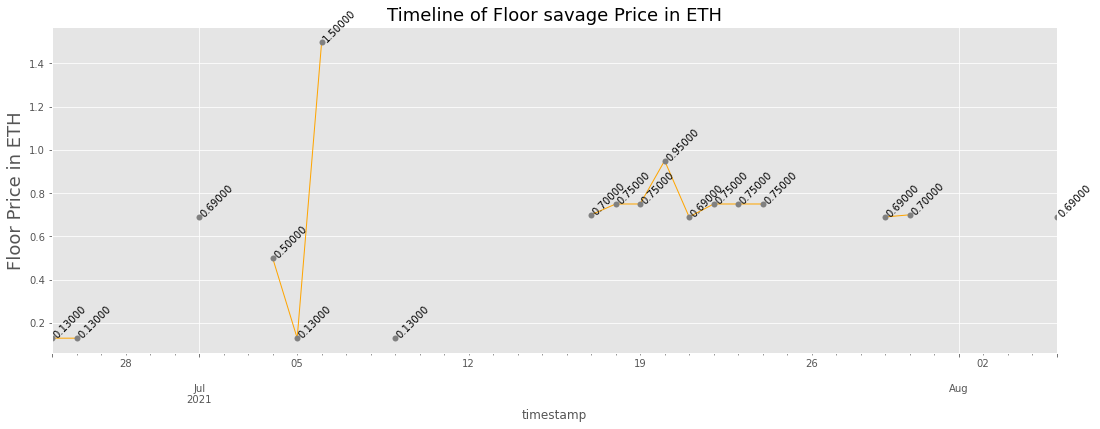

In [34]:
data = savages_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').min()['total_price']
ax = data.plot(figsize=(18,6), color="orange", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Floor savage Price in ETH", fontsize=18)
ax.set_ylabel("Floor Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for d, v in zip(dates, values):
    ax.annotate(text="{:.5f}".format(v), xy=(d, v), rotation=45);

#### Max savage Price per Day in ETH

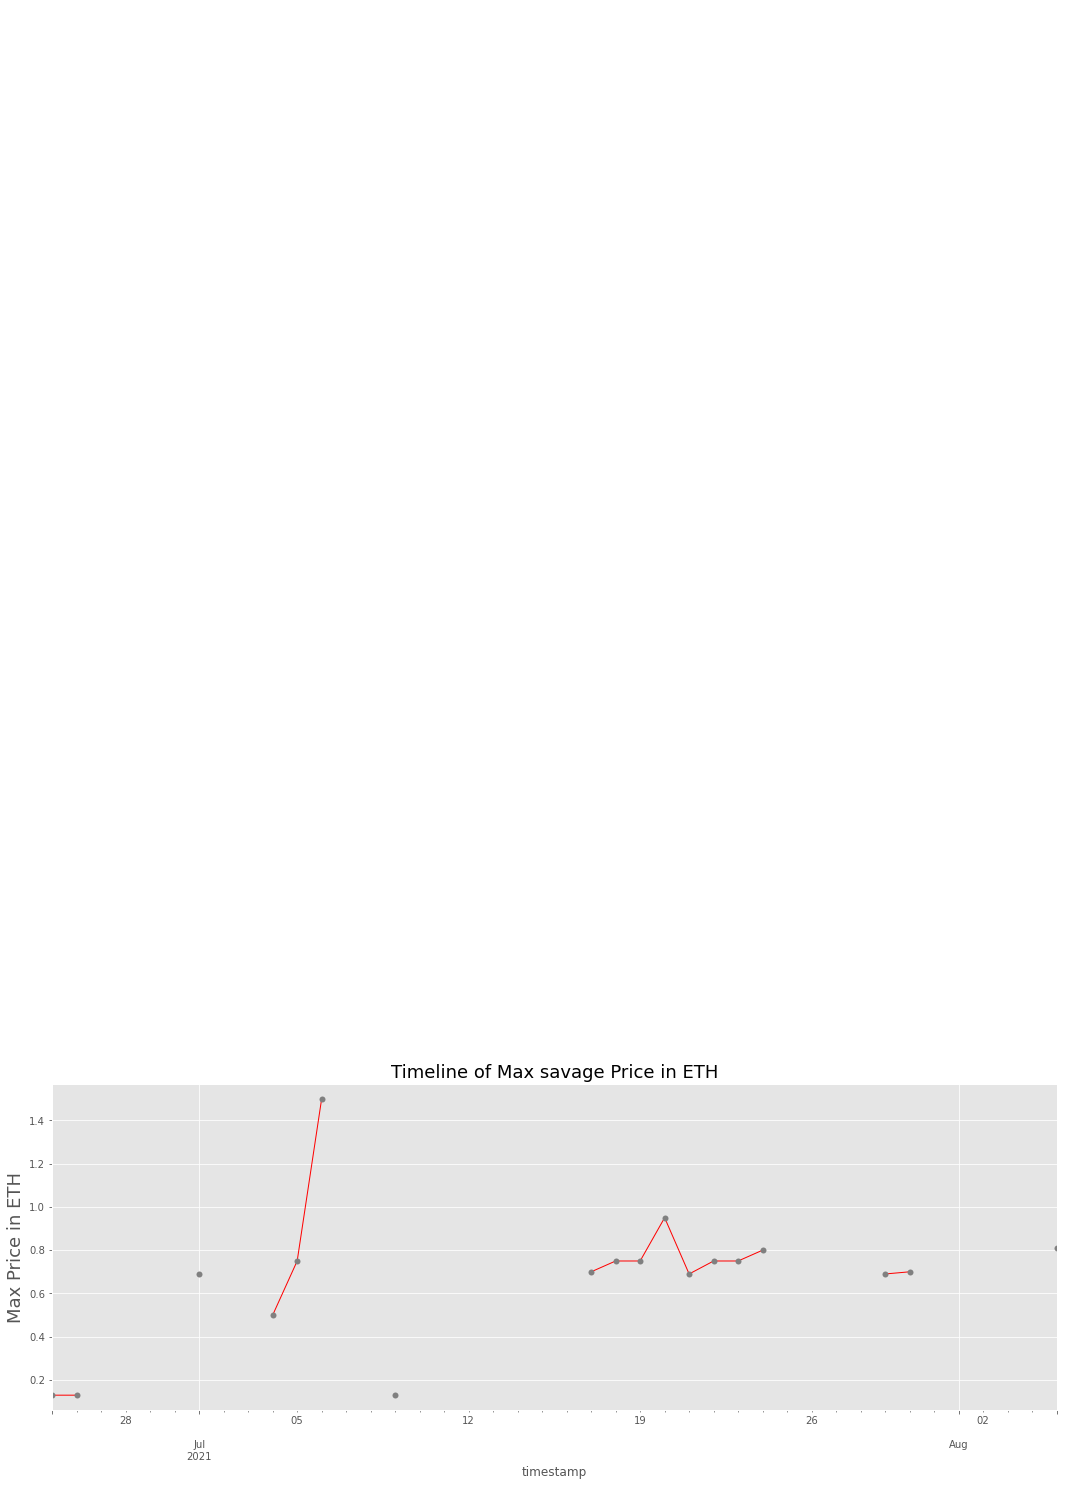

In [35]:
data = savages_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').max()['total_price']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Max savage Price in ETH", fontsize=18)
ax.set_ylabel("Max Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(text="{:.0f}".format(j), xy=(i, j+5), rotation=45);


# References

[0] [Data mining Meebits](http://adilmoujahid.com/posts/2021/06/data-mining-meebits-nfts-python-opensea/)

[1] [Fungibility - Wikipedia](https://en.wikipedia.org/wiki/Fungibility)

[2] [A Practical Introduction to NFTs using Solidity and Legos](http://adilmoujahid.com/posts/2021/05/intro-nfts-solidity/)

[3] [Counterparty - Wikipedia](https://bit.ly/3h6IfMU)

[4] [Counterparty - Bitcoinwiki](https://bit.ly/2T79teI)

[5] [Rare Pepe Gets Blockchained, Made Into Tradable Counterparty Tokens](https://news.bitcoin.com/rare-pepe-assets-get-blockchained/)